# Gaussian Processes

`jax` implementation of gaussian porcess and hyperparameter optimization.

In [8]:
import jax.numpy as np
from jax import grad, jit, vmap
import jax.scipy as scipy
from jax import random
import jax.ops as ops
import matplotlib.pyplot as plt
import seaborn
import numpy as npy
plt.style.use('seaborn-notebook')
key = random.PRNGKey(0)

## Generate RAW data to sample

In [9]:
def f(x):
    y = 0.80 * x + npy.random.normal(0.0, 1.0)
    return y

In [10]:
# Vectorize function
f = npy.vectorize(f)

In [52]:
x_train = npy.linspace(0, 10, 50)
y_train = f(x_train)

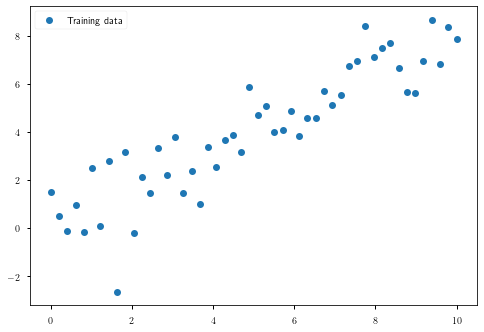

In [53]:
plt.plot(x_train, y_train, 'o', label="Training data")
plt.legend()

In [14]:
x_test = npy.random.choice(npy.linspace(0, 10, 100), 5)
y_test = f(x_test)

## Kernel

**Definition**: A kernel is a positive definite function of two inputs ($x_p$, $x_q$). These inputs are often vectors. 

$$ Cov[f(x_p), f(x_q)] = k(x_p, x_q) $$

Basically, kernels are a way for mapping the similarity between two data-points, and using these kernels we can customize how similarity between two data points is considered in a algorithm.

### Example:

Let us say we have sets of data-points, $X_{N \times D}$ and $Y_{P \times D}$. Where $D$ is the dimention of a data-point and $N,P$ is the number of data-points. Hence, when we are compute the covariance matrix between these data sets, it will have the dimention of  $N \times D$.

In [15]:
def squared_exponential(xp, xq):
    # Ensure these are one dimentional vectors
    x = xp - xq
    return np.exp(-0.5*np.dot(x, x.T))

In [16]:
def K(kernel_function, x, xs=None):
    if xs is None:
        return vmap(lambda x:vmap(lambda y: kernel_function(x, y))(x))(x)
    else:
        return vmap(lambda xp: vmap(lambda xq: squared_exponential(xp, xq))(xs))(x)

Check if the function is computing the kernel right.

In [17]:
def K_test(kernel, x, xs):
    k = np.zeros((x.shape[0], xs.shape[0])) # Number of elements in both both arrays
    for i in range(0, x.shape[0]):
        for j in range(0, xs.shape[0]):
            k = ops.index_update(k, ops.index[i,j], kernel(x[i], xs[j]))
    kn = K(kernel, x, xs)
    return k, kn

In [18]:
x = np.ones((2,5)) *0.5
xs = np.ones((3,5))
k, kjax = K_test(squared_exponential, x, x)

In [19]:
k

DeviceArray([[1., 1.],
             [1., 1.]], dtype=float32)

In [20]:
kjax

DeviceArray([[1., 1.],
             [1., 1.]], dtype=float32)

Nice !! looks like the kernel is right. 

## GP Regression

Now that the kernel looks right. Lets head over to GPs.

In [21]:
Kst = K(squared_exponential, x_test, x_train)
Ktt = K(squared_exponential, x_train, x_train) + np.eye(x_train.shape[0]) * 0.1
Kts = K(squared_exponential, x_train, x_test)
Kss = K(squared_exponential, x_test, x_test)

In [22]:
mu = np.dot(np.dot(Kst, np.linalg.inv(Ktt)), y_train)

In [23]:
Ktt_inv = np.linalg.inv(Ktt)
var = Kss - np.dot(np.dot(Kst, Ktt_inv), Kts)

In [24]:
np.sqrt(np.diag(var))

DeviceArray([0.21219178, 0.21235168, 0.21725114, 0.21214668, 0.21215525],            dtype=float32)

Looks like I need to add noise to get them to work. 

In [25]:
x_test_new = np.linspace(0, 10, 100)

In [72]:
Kst = K(squared_exponential, x_test_new, x_train)
Ktt = K(squared_exponential, x_train, x_train) + np.eye(x_train.shape[0]) * 0.20
Kts = K(squared_exponential, x_train, x_test_new)
Kss = K(squared_exponential, x_test_new, x_test_new)
mu = np.dot(np.dot(Kst, np.linalg.inv(Ktt)), y_train)
Ktt_inv = np.linalg.inv(Ktt)
var = Kss - np.dot(np.dot(Kst, Ktt_inv), Kts)
std = np.sqrt(np.diag(var))

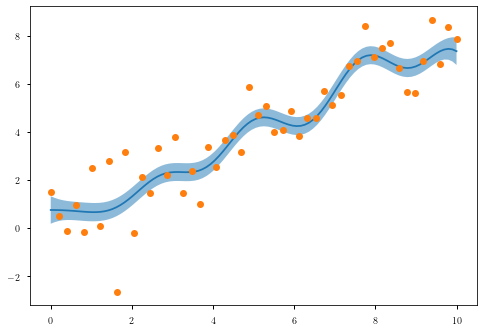

In [73]:
plt.plot(x_test_new, mu)
plt.fill_between(x_test_new, mu + 1.96*std, mu - 1.96*std, alpha=0.5)
plt.plot(x_train, y_train, 'o')

When there is IID noise in the inputs, we need a new kernel to learn that noise level. A simple squared exponential kernel might not be sufficient. Once we figure out how to tune hyperparameters, we will get back to finding the kernel design

## Hyperparamerter Tuning

In [74]:
def mlk(x, y, z):
    return 10*x+20*y+30*z

In [75]:
der = grad(mlk)

In [79]:
der(1.0, 1.0, 2.0)

DeviceArray(10., dtype=float32)